In [35]:
import os
import numpy as np 
import pandas as pd
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
CURRENT_DIR = os.getcwd()
BASE_DIR = os.path.dirname(CURRENT_DIR)
data_dir = os.path.join(BASE_DIR, 'data')

dataset_path = os.path.join(data_dir, 'telatmalambaru3.csv')
DEFAULT_MODEL_NAME = 'multi'

In [37]:
df = pd.read_csv(dataset_path, usecols=['TITLE', 'CATEGORY'])
df.head()

,TITLE,CATEGORY
0,SMP Matematika Bilangan,p
1,SMP Matematika Himpunan,p
2,SMP Matematika Bentuk Aljabar dan Operasinya,p
3,SMP Matematika Persamaan dan Pertidaksamaan Li...,p
4,SMP Matematika Perbandingan,p


In [38]:
duplicate_title_distribution = df.TITLE.value_counts()[:10]
duplicate_title_distribution

SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi                      4
SMA Matematika Peminatan Eksponen                                 2
SMA Matematika Peminatan Persamaan Lingkaran                      2
SMP Bahasa Indonesia Teks Cerita Inspiratif                       2
SMP Bahasa Indonesia Teks Ulasan                                  2
SMA Matematika Peminatan Pertidaksamaan Eksponen dan Logaritma    2
SMP Matematika Himpunan                                           2
SMA Matematika Wajib Perbandingan Trigonometri                    2
SMP Bahasa Indonesia Teks Diskusi                                 2
SMP Bahasa Indonesia Teks Iklan, Slogan, dan Poster               2
Name: TITLE, dtype: int64

In [39]:
most_common_title = duplicate_title_distribution.index[0]
most_common_title

'SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi'

In [40]:
df[df['TITLE'].str.contains(most_common_title)][:5]

,TITLE,CATEGORY
126,SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi,p
127,SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi,p
138,SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi,p
139,SMP Bahasa Indonesia Buku Fiksi dan Nonfiksi,p


In [41]:
df = df.drop_duplicates(subset='TITLE', keep=False)
df[df['TITLE'].str.contains(most_common_title)]

,TITLE,CATEGORY


In [42]:
category_dict = {
    'p': 'smp', 
    'u': 'smaumum', 
    'a': 'smaipa', 
    's': 'smaips'
}
df.CATEGORY.value_counts()

a    165
u    142
p    120
s     65
Name: CATEGORY, dtype: int64

In [43]:
category_labels = {
    'p': 'smp', 
    'u': 'smaumum', 
    'a': 'smaipa', 
    's': 'smaips'
}

In [44]:
max_num_of_labels = df.CATEGORY.value_counts()[-1]
data_df = df.copy()
shuffled_df = data_df.reindex(np.random.permutation(data_df.index))\

p = shuffled_df[shuffled_df['CATEGORY'] == 'p'][:max_num_of_labels]
u = shuffled_df[shuffled_df['CATEGORY'] == 'u'][:max_num_of_labels]
a = shuffled_df[shuffled_df['CATEGORY'] == 'a'][:max_num_of_labels]
s = shuffled_df[shuffled_df['CATEGORY'] == 's'][:max_num_of_labels]

concated_df = pd.concat([p,u,a,s], ignore_index=True)
concated_df = concated_df.reindex(np.random.permutation(concated_df.index))
concated_df['LABEL'] = 0
concated_df.head()

,TITLE,CATEGORY,LABEL
220,"SMA Geografi Usaha Ketahanan Pangan, Penyediaa...",s,0
14,SMP Bahasa Indonesia Teks Berita,p,0
28,SMP Matematika Bangun Ruang,p,0
233,SMA Geografi Pengetahuan Dasar Geografi,s,0
41,SMP Bahasa Inggris Family Members and Possessives,p,0


In [45]:
concated_df.loc[concated_df['CATEGORY'] == 'p', 'LABEL'] = 0
concated_df.loc[concated_df['CATEGORY'] == 'u', 'LABEL'] = 1
concated_df.loc[concated_df['CATEGORY'] == 'a', 'LABEL'] = 2
concated_df.loc[concated_df['CATEGORY'] == 's', 'LABEL'] = 3
print(concated_df['LABEL'][:10])
labels = to_categorical(concated_df['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated_df.keys():
    concated_df = concated_df.drop(['CATEGORY'], axis=1)
'''
 [1. 0. 0. 0.] p
 [0. 1. 0. 0.] u
 [0. 0. 1. 0.] a
 [0. 0. 0. 1.] s
'''

220    3
14     0
28     0
233    3
41     0
49     0
45     0
128    1
84     1
111    1
Name: LABEL, dtype: int64
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


'\n [1. 0. 0. 0.] p\n [0. 1. 0. 0.] u\n [0. 0. 1. 0.] a\n [0. 0. 0. 1.] s\n'

In [46]:
concated_df.head()

,TITLE,LABEL
220,"SMA Geografi Usaha Ketahanan Pangan, Penyediaa...",3
14,SMP Bahasa Indonesia Teks Berita,0
28,SMP Matematika Bangun Ruang,0
233,SMA Geografi Pengetahuan Dasar Geografi,3
41,SMP Bahasa Inggris Family Members and Possessives,0


In [47]:
n_most_common_words = 8000
max_len = 130
token_filter = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
tokenizer = Tokenizer(num_words=n_most_common_words, filters=token_filter, lower=True)
tokenizer.fit_on_texts(concated_df['TITLE'].values)

In [48]:
sequences = tokenizer.texts_to_sequences(concated_df['TITLE'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 478 unique tokens.


In [49]:
X = pad_sequences(sequences, maxlen=max_len)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [51]:
epochs = 50
emb_dim = 200
batch_size = 256
labels[:2]

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [52]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((195, 130), (195, 4), (65, 130), (65, 4))


In [53]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 200)          1600000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,668,100
Trainable params: 1,668,100
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
training = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 1.3928 - accuracy: 0.1795 - val_loss: 1.3863 - val_accuracy: 0.2308
Epoch 2/50
1/1 [==============================] - 1s 909ms/step - loss: 1.3908 - accuracy: 0.2244 - val_loss: 1.3841 - val_accuracy: 0.2821
Epoch 3/50
1/1 [==============================] - 1s 998ms/step - loss: 1.3885 - accuracy: 0.2692 - val_loss: 1.3822 - val_accuracy: 0.2564
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 1.3810 - accuracy: 0.2756 - val_loss: 1.3802 - val_accuracy: 0.2308
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 1.3708 - accuracy: 0.3590 - val_loss: 1.3783 - val_accuracy: 0.2308
Epoch 6/50
1/1 [==============================] - 1s 961ms/step - loss: 1.3714 - accuracy: 0.3077 - val_loss: 1.3765 - val_accuracy: 0.2308
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 1.3669 - accuracy: 0.3462 - val_loss: 1.3747 - val_accuracy: 0.2308
Epoch 8/50
1/1 [================

In [55]:
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3/3 [==============================] - 0s 36ms/step - loss: 0.6354 - accuracy: 0.9077
Test set
  Loss: 0.635
  Accuracy: 0.908


In [56]:
accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']

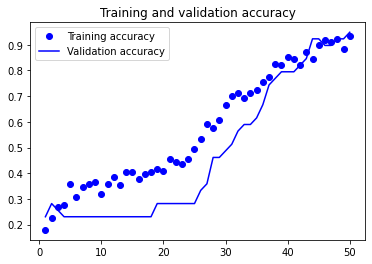

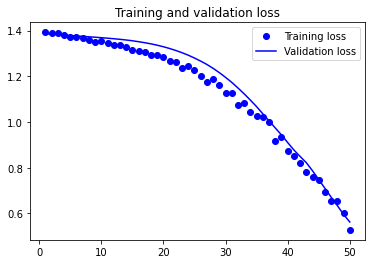

In [57]:
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [58]:
txt = ["SMP Matematika Peluang"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['smp', 'smaumum', 'smaipa', 'smaips']
print(pred, labels[np.argmax(pred)])

[[0.4312568  0.23268875 0.1925935  0.14346093]] smp


In [59]:
def extract_label(index):
    '''
    The labels correspond to exact label indices, in other words, the 
    order is absolutely important.
    '''
    labels = ['smp', 'smaumum', 'smaipa', 'smaips']
    return labels[index]

In [60]:
def predict(text, model_klass=model):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model_klass.predict(padded)
    top_prediction_index = np.argmax(pred)
    predicted_label = extract_label(top_prediction_index)
    predictions = pred.tolist()[0]
    extracted_predictions = [{extract_label(i):"%.2f%%"%(x*100)} for i, x in enumerate(predictions)]
    top_percent = "%.2f%%"% (predictions[top_prediction_index] * 100)
    print(f"{text}\t\t{top_percent} {predicted_label}")
    return extracted_predictions

In [61]:
predict("SMA Fisika Kimia Biologi")

SMA Fisika Kimia Biologi		92.18% smaipa


[{'smp': '0.76%'},
 {'smaumum': '2.46%'},
 {'smaipa': '92.18%'},
 {'smaips': '4.60%'}]

In [62]:
predict("SMA Bahasa Inggris Bahasa Indonesia Matematika Wajib")

SMA Bahasa Inggris Bahasa Indonesia Matematika Wajib		59.00% smaumum


[{'smp': '26.52%'},
 {'smaumum': '59.00%'},
 {'smaipa': '7.21%'},
 {'smaips': '7.27%'}]

In [63]:
predict("SMA Kimia Dan Ekonomi Sosiologi")

SMA Kimia Dan Ekonomi Sosiologi		61.58% smaips


[{'smp': '2.98%'},
 {'smaumum': '4.84%'},
 {'smaipa': '30.59%'},
 {'smaips': '61.58%'}]

In [64]:
predict("Sejarah Ekonomi dan Sosiologi")

Sejarah Ekonomi dan Sosiologi		67.84% smaips


[{'smp': '12.68%'},
 {'smaumum': '6.48%'},
 {'smaipa': '12.99%'},
 {'smaips': '67.84%'}]

In [65]:
predict("Matematika Fisika Kimia Sosiologi")

Matematika Fisika Kimia Sosiologi		60.19% smaipa


[{'smp': '7.48%'},
 {'smaumum': '11.12%'},
 {'smaipa': '60.19%'},
 {'smaips': '21.21%'}]

In [66]:
predict("SD Belajar Matematika Dasar")

SD Belajar Matematika Dasar		44.81% smaipa


[{'smp': '14.59%'},
 {'smaumum': '25.21%'},
 {'smaipa': '44.81%'},
 {'smaips': '15.39%'}]

In [67]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


In [34]:
!tensorflowjs_converter \
    --input_format=keras_saved_model \
    ./saved_model\
    ./json_keras_model

2021-06-07 18:22:23.274460: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-07 18:22:23.274521: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-06-07 18:22:30.864902: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-06-07 18:22:30.867588: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-06-07 18:22:31.191680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce 920M computeCapability: 3.5
coreClock: 0.954GHz coreCount: 2 deviceMemorySize: 2.00GiB deviceMemoryBandwidth: 13.41GiB/s
2021-06-07 18:22:31.192852: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynam